# Problem Statement

Credit Card Lead Prediction
Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)


Data Dictionary

Train Data

|Variable|Definition|
|--------|----------|
|ID|Unique Identifier for a row|
|Gender|Gender of the Customer|
|Age|Age of the Customer (in Years)|
|Region_Code|Code of the Region for the customers|
|Occupation|Occupation Type for the customer|
|Channel_Code|Acquisition Channel Code for the Customer  (Encoded)|
|Vintage|Vintage for the Customer (In Months)|
|Credit_Product|If the Customer has any active credit product (Home loan,Personal loan, Credit Card etc.)|
|Avg_Account_Balance|Average Account Balance for the Customer in last 12 Months|
|Is_Active|If the Customer is Active in last 3 Months|
|Is_Lead(Target)|If the Customer is interested for the Credit Card 0 : Customer is not interested 1 : Customer is interested|


Test Data

|Variable|Definition|
|--------|----------|
|ID|Unique Identifier for a row|
|Gender|Gender of the Customer|
|Age|Age of the Customer (in Years)|
|Region_Code|Code of the Region for the customers|
|Occupation|Occupation Type for the customer|
|Channel_Code|Acquisition Channel Code for the Customer  (Encoded)|
|Vintage|Vintage for the Customer (In Months)|
|Credit_Product|If the Customer has any active credit product (Home loan,Personal loan, Credit Card etc.)|
|Avg_Account_Balance|Average Account Balance for the Customer in last 12 Months|
|Is_Active|If the Customer is Active in last 3 Months|

Sample Submission
This file contains the exact submission format for the predictions. Please submit CSV file only.

|Variable|	Definition|
|--------|------------|
|ID|	Unique Identifier for a row|
|Is_Lead	(Target)| Probability of Customer showing interest (class 1)|




In [190]:
# !pip install pycaret
# !pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer
import xgboost as xgb
from tqdm import tqdm_notebook
from sklearn.metrics import roc_curve,precision_recall_curve
from catboost import Pool, cv, CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
rf_model = RandomForestClassifier(class_weight='balanced')
import lightgbm as lgb
from sklearn.cluster import KMeans
from scipy.stats import kurtosis, iqr
from sklearn.preprocessing import LabelEncoder,StandardScaler

CONFIG

In [191]:
DATA_PATH = '/content/drive/MyDrive/Jobathon_may_2021/'
TRAIN_PATH = DATA_PATH + 'train.csv'
TEST_PATH = DATA_PATH + 'test.csv'

CATEGORICAL_COL = ['GENDER','REGION_CODE', 'OCCUPATION','CHANNEL_CODE',\
                   'CREDIT_PRODUCT','IS_ACTIVE']

UTIL FUNCTIONS

In [192]:
def evaluate_model(y_true, y_pred):
  print('ROC_AUC')
  print('***************************')
  print(roc_auc_score(y_true,y_pred))

def upper_case_columns(df):
  '''
  Convert case of columns in dataframe
  '''
  df.columns = [x.upper() for x in df.columns]
  return df


def miss_data(df):
  '''
  To summarise details of missing values in a dataframe
  '''
  x = ['column_name','missing_data', 'missing_in_percentage']
  missing_data = pd.DataFrame(columns=x)
  columns = df.columns
  for col in columns:
      icolumn_name = col
      imissing_data = df[col].isnull().sum()
      imissing_in_percentage = (df[col].isnull().sum()/df[col].shape[0])*100

      missing_data.loc[len(missing_data)] = [icolumn_name, imissing_data, imissing_in_percentage]
  print(missing_data)

def split(df):
  x_train, x_val, y_train, y_val = train_test_split(df.drop(['IS_LEAD','IS_TRAIN','ID','KFOLD'], axis=1), \
                                                  df['IS_LEAD'].astype('int'),
                                                    test_size=0.20,shuffle=True,
                                                    random_state=0,
                                                    stratify=df['IS_LEAD'])
  return x_train, x_val, y_train, y_val

ANALYSIS

In [204]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# change column case
train = upper_case_columns(train)
test = upper_case_columns(test)

train['IS_TRAIN'] = 1
test['IS_TRAIN'] = 0

In [205]:
# splitting data in to 5 folds

train['KFOLD'] = -1

kf = StratifiedKFold(n_splits=5)

for f, (train_idx, valid_idx) in enumerate(kf.split(X = train, y = train['IS_LEAD'].values)):
  train.loc[valid_idx,'KFOLD'] = f

In [206]:
print('Number of records in train set', train.shape[0])
print('Number of records in test set', test.shape[0])

Number of records in train set 245725
Number of records in test set 105312


In [207]:
# check target column distribution
train['IS_LEAD'].value_counts(normalize=True)

0    0.762792
1    0.237208
Name: IS_LEAD, dtype: float64

Target class distribution is skewed with 75% of data belonging to the class 0

In [208]:
miss_data(train), miss_data(test)

            column_name missing_data  missing_in_percentage
0                    ID            0               0.000000
1                GENDER            0               0.000000
2                   AGE            0               0.000000
3           REGION_CODE            0               0.000000
4            OCCUPATION            0               0.000000
5          CHANNEL_CODE            0               0.000000
6               VINTAGE            0               0.000000
7        CREDIT_PRODUCT        29325              11.934073
8   AVG_ACCOUNT_BALANCE            0               0.000000
9             IS_ACTIVE            0               0.000000
10              IS_LEAD            0               0.000000
11             IS_TRAIN            0               0.000000
12                KFOLD            0               0.000000
            column_name missing_data  missing_in_percentage
0                    ID            0               0.000000
1                GENDER            0    

(None, None)

Only credit product has 11% of missing values in both train and test set

In [209]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   GENDER               245725 non-null  object
 2   AGE                  245725 non-null  int64 
 3   REGION_CODE          245725 non-null  object
 4   OCCUPATION           245725 non-null  object
 5   CHANNEL_CODE         245725 non-null  object
 6   VINTAGE              245725 non-null  int64 
 7   CREDIT_PRODUCT       216400 non-null  object
 8   AVG_ACCOUNT_BALANCE  245725 non-null  int64 
 9   IS_ACTIVE            245725 non-null  object
 10  IS_LEAD              245725 non-null  int64 
 11  IS_TRAIN             245725 non-null  int64 
 12  KFOLD                245725 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 24.4+ MB


In the dataset, 3 continuous columns are available and rest are categorical columns

In [210]:
print('Number of unique elements in each column')
print('******************************************')
for i in train.columns:
  uniq = train[i].nunique()
  print(f'{i}: {uniq}')

Number of unique elements in each column
******************************************
ID: 245725
GENDER: 2
AGE: 63
REGION_CODE: 35
OCCUPATION: 4
CHANNEL_CODE: 4
VINTAGE: 66
CREDIT_PRODUCT: 2
AVG_ACCOUNT_BALANCE: 135292
IS_ACTIVE: 2
IS_LEAD: 2
IS_TRAIN: 1
KFOLD: 5


ID is a unique element in the dataset. Age column is continous with only 63 different values and Vintage column is continous with only 66 different values

EDA

In [211]:
def col_plot(train, col):
  fig, ax = plt.subplots(1, 2, figsize=(14, 4))
  train[train['IS_LEAD'] == 0][col].value_counts(normalize=True).plot(kind='bar',ax=ax[0]).set_title('NOT INTERESTED')
  train[train['IS_LEAD'] == 1][col].value_counts(normalize=True).plot(kind='bar',ax=ax[1]).set_title('INTERESTED')
  plt.suptitle(col)
  plt.show()

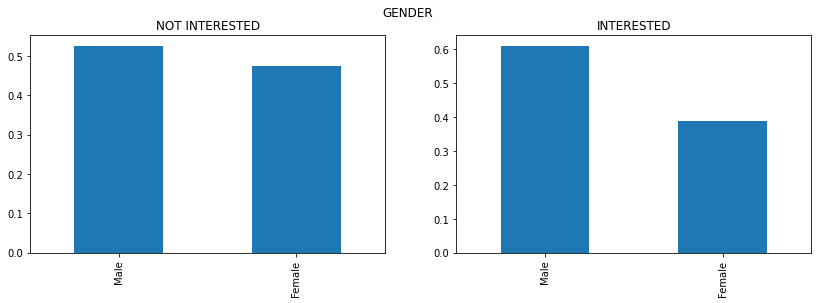

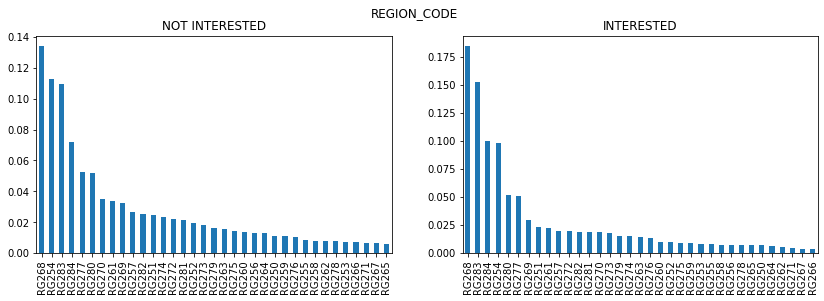

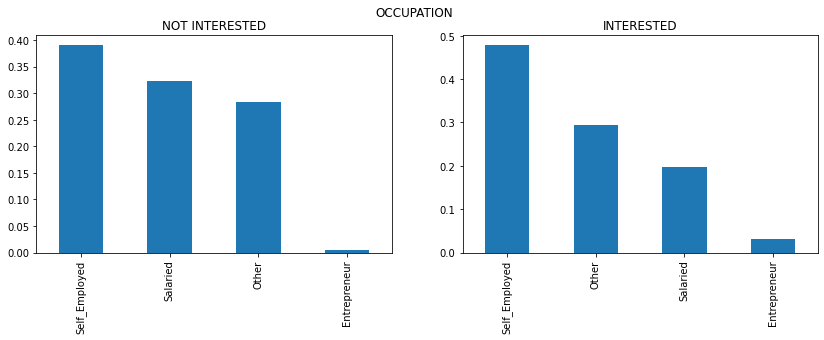

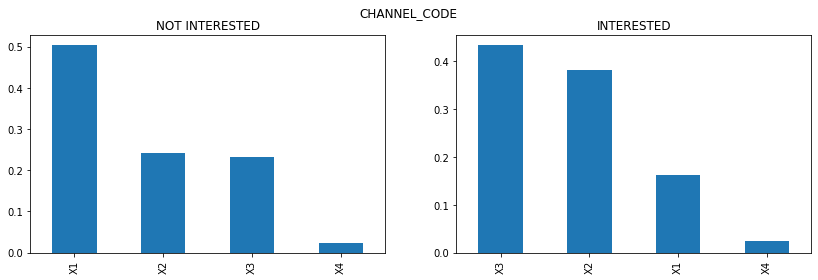

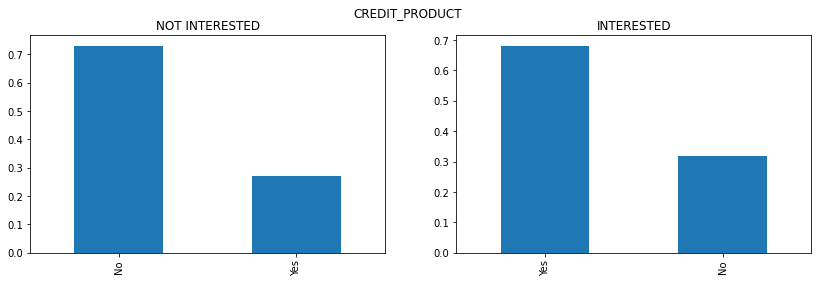

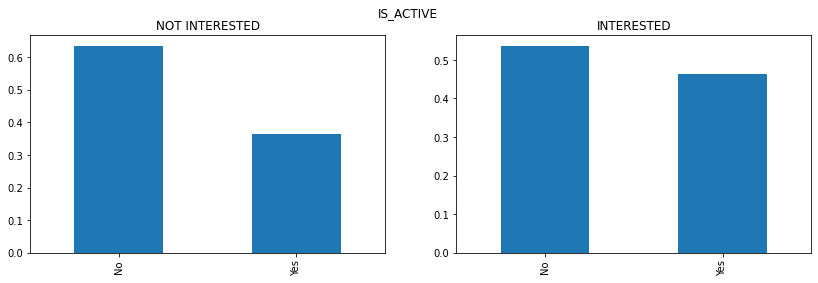

In [201]:
for i in CATEGORICAL_COL:
  col_plot(train,i)

Dealing with MISSING values and Categorical columns

In [212]:
# missing values are available only in credit product column and considered as sepearate category

train['CREDIT_PRODUCT'].fillna('None', inplace=True)
test['CREDIT_PRODUCT'].fillna('None', inplace=True)


FIND OPTIMAL MODEL using CV

In [213]:
# encode the categorical values
encoder = LabelEncoder()

for c in CATEGORICAL_COL:
    train[c] = encoder.fit_transform(train[c])
    test[c] = encoder.transform(test[c])

In [214]:
x_train,  x_val, y_train, y_val = split(train)

LGBM

In [ ]:

lightgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'class_weight':'balanced'
}

d_train = lgb.Dataset(x_train, label=y_train)
lg_cv = lgb.cv(lightgbm_params, d_train,nfold=5, 
               verbose_eval=20, early_stopping_rounds=40, shuffle=False)

In [ ]:
print('Best CV score:', np.mean(lg_cv['auc-mean']))

Best CV score: 0.8724213313135205


CATBOOST

In [ ]:
params = {"iterations": 100,
          "loss_function": "Logloss",
          'custom_metric':'AUC',
          'class_weights':[1,3],
          "verbose": False}

cv_data = Pool(data=x_train,
                  label=y_train)

scores = cv(cv_data,
            params,
            fold_count=5, shuffle=False)


In [ ]:
scores['test-AUC-mean'].max()

0.8715988266015042

XGBOOST and ADABOOST

In [ ]:
xgtrain = xgb.DMatrix(x_train, y_train )
model_xg=xgb.XGBClassifier(random_state=0, scale_pos_weight=3)
xgb_param = model_xg.get_xgb_params()

xg_cv = xgb.cv(xgb_param, xgtrain, nfold=5, metrics='auc', seed=0)

In [ ]:
xg_cv

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.870913,0.000635,0.869575,0.002480
1,0.871968,0.000496,0.870376,0.002349
2,0.872788,0.000564,0.870754,0.002223
3,0.873751,0.000566,0.871609,0.002306
4,0.874107,0.000616,0.871781,0.002287
5,0.874642,0.000716,0.872052,0.002163
6,0.875122,0.000639,0.872295,0.002190
7,0.875581,0.000504,0.872522,0.002298
8,0.876051,0.000604,0.872745,0.002211
9,0.876688,0.000558,0.872974,0.002238


In [ ]:
rf_model = RandomForestClassifier(class_weight='balanced')
rf = cross_validate(rf_model, x_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

In [ ]:
np.mean(rf['test_score'])

0.8525026413479596

FEATURE ENGINEERING

In [ ]:
train['IS_TRAIN'] = 1
test['IS_TRAIN'] = 0

df = pd.concat([train, test])

In [ ]:

def get_kurtosis(arr):
  kurt = kurtosis(arr)
  return kurt

def get_iqr(arr):
  iqr_val = iqr(arr)
  return iqr_val 

def get_range(arr):
  range_val = np.ptp(arr)
  return range_val

In [ ]:
def get_agg_cols(train, col):
    train[f'{col}_MEAN_{i}'] = train.groupby(['REGION_CODE'])[col].transform('mean')
    train[f'{col}_STD_{i}'] = train.groupby(['REGION_CODE'])[col].transform('std')
    train[f'{col}_SKEW_{i}'] = train.groupby(['REGION_CODE'])[col].transform('skew')
    train[f'{col}_KURTOSIS_{i}'] = train.groupby(['REGION_CODE'])[col].transform(get_kurtosis)
    train[f'{col}_IQR_{i}'] = train.groupby(['REGION_CODE'])[col].transform(get_iqr)
    train[f'{col}_RANGE_{i}'] = train.groupby(['REGION_CODE'])[col].transform(get_range)
    return train


In [ ]:
# Aggregate values based on regional code on account balance

df = get_agg_cols(df,'AVG_ACCOUNT_BALANCE')

In [ ]:
def binning_col(train, col):
  # no of bins and edges 
  hist, bin_edg = np.histogram(train[col].values,bins='sturges')
  Bin = KBinsDiscretizer(n_bins=6, encode='ordinal', strategy='kmeans')
  train[f'{col}_BIN'] = Bin.fit_transform(train[col].values.reshape(-1, 1))
  return train

# binning age and vintage
df = binning_col(df,'AGE')
df = binning_col(df,'VINTAGE')

CATEGORICAL_COL += ['AGE_BIN','VINTAGE_BIN']

In [ ]:
# ratio features 

df['RATIO_AGE_VINTAGE'] = np.log(df['AGE']/df['VINTAGE'])
df['RATIO_AC_BAL_AGE'] = np.log(df['AVG_ACCOUNT_BALANCE']/df['AGE'])
df['AVG_ACCOUNT_BALANCE'] = np.log(df['AVG_ACCOUNT_BALANCE'])
df['AGE'] = np.log(df['AGE'])
df['VINTAGE'] = np.log(df['VINTAGE'])

In [ ]:
def target_encoding(train, valid, test):
  for c in CATEGORICAL_COL:
    val_dict = train.groupby([c]).agg({'IS_LEAD':'mean'}).to_dict()['IS_LEAD']
    train[f'{c}_TARGET_ENCODING'] = train[c].map(val_dict)
    valid[f'{c}_TARGET_ENCODING'] = valid[c].map(val_dict)
    test[f'{c}_TARGET_ENCODING'] = test[c].map(val_dict)
  return train, valid, test


In [ ]:
# ENCODING the categorical columns

train = df[df['IS_TRAIN']==1]
test = df[df['IS_TRAIN']==0]

encoder = LabelEncoder()

for c in CATEGORICAL_COL:
    train[c] = encoder.fit_transform(train[c])
    test[c] = encoder.transform(test[c])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


From the CV results LGBM found to be the best model tunning its parameter

HYPERPARAMETER TUNING

In [ ]:
# Objective Function
dtrain = lgb.Dataset(data=x_train, label=y_train, free_raw_data=False)

def lgb_eval(learning_rate,num_leaves, feature_fraction,\
             bagging_fraction, max_depth, \
             lambda_l1, lambda_l2,\
             min_split_gain, min_child_weight,subsample):
        params = {'application':'binary','num_iterations': 1500,
                  'early_stopping_round':150,'class_weight':'balanced',
                  'metric':'auc'} # ,'boost_from_average':False}
        params['learning_rate'] = max(min(learning_rate, 1), 0)          
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight,
        params['subsample'] = max(min(subsample, 1), 0)
        cv_result = lgb.cv(params, dtrain, nfold=5, seed=11,
                           stratified=True,categorical_feature= CATEGORICAL_COL,
                            verbose_eval =None)
        return max(cv_result['auc-mean'])

pbs = {'learning_rate': (0.01, 1.0),
    'num_leaves': (200, 400),
        'feature_fraction': (0.1, 0.9),
        'bagging_fraction': (0.8, 1),
        'max_depth': (11, 29),
        'lambda_l1': (0, 2),
        'lambda_l2': (0, 3),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (1, 10),
       'subsample': (0.01, 1.0)
      }


from bayes_opt import BayesianOptimization
optimizer = BayesianOptimization(lgb_eval, pbs, random_state=0)
optimizer.maximize(init_points=5, n_iter=30)

In [ ]:
optimizer.max['params']

{'bagging_fraction': 0.8311485666872785,
 'feature_fraction': 0.8379604070873502,
 'lambda_l1': 1.9965195846273445,
 'lambda_l2': 2.3749163983987684,
 'learning_rate': 0.010966236844973847,
 'max_depth': 12.421995123923814,
 'min_child_weight': 4.3310407596078795,
 'min_split_gain': 0.04390640960548089,
 'num_leaves': 200.9699390530843,
 'subsample': 0.25565702591322664}

Using the best two models to ensemble the results
to train and predict on unseen data

In [183]:
test_pred = []
thresh = []
for i in tqdm_notebook(range(5)):
  x_train = train[train['KFOLD']!=i].drop(['ID','IS_LEAD','IS_TRAIN','KFOLD'], axis=1)
  y_train = train[train['KFOLD']!=i]['IS_LEAD']
  x_val = train[train['KFOLD']==i].drop(['ID','IS_LEAD','IS_TRAIN','KFOLD'], axis=1)
  y_val = train[train['KFOLD']==i]['IS_LEAD']

  # creating model
  model_lgbm  = lgb.LGBMClassifier(class_weight = 'balanced',
                                 objective = 'binary', 
                                 silent=True,
                                 iterations = 200,
                                 boosting_type = 'gbdt',
                                 bagging_fraction = 0.83,
                                 feature_fraction = 0.84,
                                lambda_l1 = 2,
                                # lambda_l2 = 2.37,
                                # learning_rate = 0.011,
                                # max_depth = 12,
                                min_child_weight = 4,
                                # min_split_gain = 0.04,
                                num_leaves = 201,
                                subsample = 0.25,
                                 min_data_in_leaf=307, 
                                 max_depth=7, 
                                 learning_rate=0.1)
  
  cat = CatBoostClassifier(class_weights=[1,3],
                           iterations = 200,
                           learning_rate = 0.06,
                           depth = 8,
                           l2_leaf_reg = 21, 
                           eval_metric='AUC', 
                           silent=True)
  CAT_IND = x_train.columns.get_indexer(CATEGORICAL_COL)

  model_lgbm.fit(x_train, y_train, categorical_feature = CATEGORICAL_COL, 
                 eval_metric='auc', eval_set=[(x_val,y_val)])
  cat.fit(x_train, y_train, cat_features=CAT_IND, eval_set = [(x_val, y_val)])

  val_pred1 = model_lgbm.predict_proba(x_val)[:,1]
  val_pred2 = cat.predict_proba(x_val)[:,1]
 
  val_pred = 0.6*val_pred1 + 0.4*val_pred2
  print(evaluate_model(y_val, val_pred))
  pred1 = model_lgbm.predict_proba(test[x_train.columns])[:,1]
  pred2 = cat.predict_proba(test[x_train.columns])[:,1]
  pred = 0.6*pred1 + 0.4*pred2
  test_pred.append(pred)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE_BIN', 'CHANNEL_CODE', 'CREDIT_PRODUCT', 'GENDER', 'IS_ACTIVE', 'OCCUPATION', 'REGION_CODE', 'VINTAGE_BIN']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.86438	valid_0's binary_logloss: 0.652738
[2]	valid_0's auc: 0.865697	valid_0's binary_logloss: 0.619802
[3]	valid_0's auc: 0.868454	valid_0's binary_logloss: 0.591208
[4]	valid_0's auc: 0.86913	valid_0's binary_logloss: 0.567482
[5]	valid_0's auc: 0.869036	valid_0's binary_logloss: 0.547724
[6]	valid_0's auc: 0.86967	valid_0's binary_logloss: 0.530663
[7]	valid_0's auc: 0.869906	valid_0's binary_logloss: 0.516289
[8]	valid_0's auc: 0.869893	valid_0's binary_logloss: 0.504016
[9]	valid_0's auc: 0.869843	valid_0's binary_logloss: 0.493318
[10]	valid_0's auc: 0.870038	valid_0's binary_logloss: 0.484577
[11]	valid_0's auc: 0.870098	valid_0's binary_logloss: 0.476903
[12]	valid_0's auc: 0.869915	valid_0's binary_logloss: 0.470584
[13]	valid_0's auc: 0.870114	valid_0's binary_logloss: 0.4673
[14]	valid_0's auc: 0.869965	valid_0's binary_logloss: 0.462245
[15]	valid_0's auc: 0.869998	valid_0's binary_logloss: 0.457587
[16]	valid_0's auc: 0.870477	valid_0's binary_logloss:

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE_BIN', 'CHANNEL_CODE', 'CREDIT_PRODUCT', 'GENDER', 'IS_ACTIVE', 'OCCUPATION', 'REGION_CODE', 'VINTAGE_BIN']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.864401	valid_0's binary_logloss: 0.652544
[2]	valid_0's auc: 0.865864	valid_0's binary_logloss: 0.619643
[3]	valid_0's auc: 0.869333	valid_0's binary_logloss: 0.590865
[4]	valid_0's auc: 0.870056	valid_0's binary_logloss: 0.566993
[5]	valid_0's auc: 0.870436	valid_0's binary_logloss: 0.547061
[6]	valid_0's auc: 0.870705	valid_0's binary_logloss: 0.529911
[7]	valid_0's auc: 0.870852	valid_0's binary_logloss: 0.515362
[8]	valid_0's auc: 0.871115	valid_0's binary_logloss: 0.502991
[9]	valid_0's auc: 0.871372	valid_0's binary_logloss: 0.49215
[10]	valid_0's auc: 0.871189	valid_0's binary_logloss: 0.483424
[11]	valid_0's auc: 0.871306	valid_0's binary_logloss: 0.475628
[12]	valid_0's auc: 0.871051	valid_0's binary_logloss: 0.469335
[13]	valid_0's auc: 0.871563	valid_0's binary_logloss: 0.466027
[14]	valid_0's auc: 0.871434	valid_0's binary_logloss: 0.460965
[15]	valid_0's auc: 0.871492	valid_0's binary_logloss: 0.456216
[16]	valid_0's auc: 0.871774	valid_0's binary_logl

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE_BIN', 'CHANNEL_CODE', 'CREDIT_PRODUCT', 'GENDER', 'IS_ACTIVE', 'OCCUPATION', 'REGION_CODE', 'VINTAGE_BIN']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.866832	valid_0's binary_logloss: 0.652526
[2]	valid_0's auc: 0.867813	valid_0's binary_logloss: 0.619449
[3]	valid_0's auc: 0.869735	valid_0's binary_logloss: 0.590765
[4]	valid_0's auc: 0.87055	valid_0's binary_logloss: 0.566908
[5]	valid_0's auc: 0.870725	valid_0's binary_logloss: 0.547056
[6]	valid_0's auc: 0.870846	valid_0's binary_logloss: 0.52999
[7]	valid_0's auc: 0.871185	valid_0's binary_logloss: 0.515552
[8]	valid_0's auc: 0.871232	valid_0's binary_logloss: 0.503235
[9]	valid_0's auc: 0.871453	valid_0's binary_logloss: 0.49248
[10]	valid_0's auc: 0.871616	valid_0's binary_logloss: 0.483732
[11]	valid_0's auc: 0.87167	valid_0's binary_logloss: 0.475776
[12]	valid_0's auc: 0.871592	valid_0's binary_logloss: 0.469381
[13]	valid_0's auc: 0.871963	valid_0's binary_logloss: 0.466136
[14]	valid_0's auc: 0.871856	valid_0's binary_logloss: 0.460999
[15]	valid_0's auc: 0.871904	valid_0's binary_logloss: 0.456208
[16]	valid_0's auc: 0.872157	valid_0's binary_logloss

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE_BIN', 'CHANNEL_CODE', 'CREDIT_PRODUCT', 'GENDER', 'IS_ACTIVE', 'OCCUPATION', 'REGION_CODE', 'VINTAGE_BIN']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.865596	valid_0's binary_logloss: 0.652851
[2]	valid_0's auc: 0.867336	valid_0's binary_logloss: 0.62011
[3]	valid_0's auc: 0.8697	valid_0's binary_logloss: 0.59175
[4]	valid_0's auc: 0.870279	valid_0's binary_logloss: 0.568115
[5]	valid_0's auc: 0.870539	valid_0's binary_logloss: 0.54862
[6]	valid_0's auc: 0.870913	valid_0's binary_logloss: 0.531671
[7]	valid_0's auc: 0.870894	valid_0's binary_logloss: 0.517373
[8]	valid_0's auc: 0.871553	valid_0's binary_logloss: 0.505111
[9]	valid_0's auc: 0.871588	valid_0's binary_logloss: 0.494565
[10]	valid_0's auc: 0.871594	valid_0's binary_logloss: 0.485956
[11]	valid_0's auc: 0.871671	valid_0's binary_logloss: 0.478217
[12]	valid_0's auc: 0.871441	valid_0's binary_logloss: 0.472011
[13]	valid_0's auc: 0.871989	valid_0's binary_logloss: 0.468732
[14]	valid_0's auc: 0.871867	valid_0's binary_logloss: 0.463751
[15]	valid_0's auc: 0.871913	valid_0's binary_logloss: 0.459102
[16]	valid_0's auc: 0.872077	valid_0's binary_logloss:

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['AGE_BIN', 'CHANNEL_CODE', 'CREDIT_PRODUCT', 'GENDER', 'IS_ACTIVE', 'OCCUPATION', 'REGION_CODE', 'VINTAGE_BIN']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's auc: 0.86646	valid_0's binary_logloss: 0.652583
[2]	valid_0's auc: 0.867969	valid_0's binary_logloss: 0.619694
[3]	valid_0's auc: 0.870693	valid_0's binary_logloss: 0.59104
[4]	valid_0's auc: 0.871492	valid_0's binary_logloss: 0.567175
[5]	valid_0's auc: 0.871516	valid_0's binary_logloss: 0.547345
[6]	valid_0's auc: 0.871859	valid_0's binary_logloss: 0.530211
[7]	valid_0's auc: 0.872259	valid_0's binary_logloss: 0.51559
[8]	valid_0's auc: 0.872489	valid_0's binary_logloss: 0.503244
[9]	valid_0's auc: 0.872925	valid_0's binary_logloss: 0.492367
[10]	valid_0's auc: 0.872881	valid_0's binary_logloss: 0.483576
[11]	valid_0's auc: 0.873033	valid_0's binary_logloss: 0.475661
[12]	valid_0's auc: 0.872887	valid_0's binary_logloss: 0.469255
[13]	valid_0's auc: 0.873289	valid_0's binary_logloss: 0.46588
[14]	valid_0's auc: 0.873089	valid_0's binary_logloss: 0.46079
[15]	valid_0's auc: 0.873173	valid_0's binary_logloss: 0.456033
[16]	valid_0's auc: 0.87337	valid_0's binary_logloss: 

In [161]:
train.head()

,ID,GENDER,AGE,REGION_CODE,OCCUPATION,CHANNEL_CODE,VINTAGE,CREDIT_PRODUCT,AVG_ACCOUNT_BALANCE,IS_ACTIVE,IS_LEAD,KFOLD,IS_TRAIN,AVG_ACCOUNT_BALANCE_MEAN_0,AVG_ACCOUNT_BALANCE_STD_0,AVG_ACCOUNT_BALANCE_SKEW_0,AVG_ACCOUNT_BALANCE_KURTOSIS_0,AVG_ACCOUNT_BALANCE_IQR_0,AVG_ACCOUNT_BALANCE_RANGE_0,AGE_BIN,VINTAGE_BIN,RATIO_AGE_VINTAGE,RATIO_AC_BAL_AGE
0,NNVBBKZB,0,4.290459,18,1,2,3.761200,0,13.860193,0,0.0,0.0,1,14.201545,13.831297,0.897308,2.248605,13.808118,16.148243,4,1,0.529259,9.569734
1,IDD62UNG,0,3.401197,27,2,0,3.465736,0,13.274205,0,0.0,0.0,1,13.796163,13.463322,1.255523,3.128844,13.313663,16.076526,0,1,-0.064539,9.873008
2,HD3DSEMC,0,4.025352,18,3,2,3.258097,0,14.210464,1,0.0,0.0,1,14.201545,13.831297,0.897308,2.248605,13.808118,16.148243,3,0,0.767255,10.185112
3,BF3NC7KV,1,3.526361,20,2,0,2.944439,0,13.061453,0,0.0,0.0,1,13.453147,12.886357,1.122560,3.110711,12.737262,15.895963,1,0,0.581922,9.535093
4,TEASRWXV,0,3.401197,32,2,0,3.496508,0,13.695360,0,0.0,0.0,1,13.774688,13.165286,0.886108,2.794600,13.233459,15.930395,0,1,-0.095310,10.294163


In [186]:
test_pred1 = np.mean(test_pred, axis=0)

test['Is_Lead'] = test_pred1

test[['ID','Is_Lead']].to_csv('baseline.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
